<div >
<img src = "figs/ans_banner_1920x200.png" />
</div>

# Caso-taller:  Analizando el Delito en Chicago

En este caso-taller vamos a utilizar datos geográficos y estimación de densidad de kernel para analizar delitos en Chicago. Esta ciudad es muy famosa no sólo por haber sido el hogar del mafioso Al Capone, sino también por sus altas tasas de delitos. 

Para este taller obtuve datos del portal de la [ciudad de Chicago](https://www.chicago.gov/city/en/dataset/crime.html). La base de datos fue traducida y modificada para nuestras necesidades. Esta contiene todos los homicidios y robos que sucedieron entre el 1 de junio y el 31 de agosto de 2019.


## Instrucciones generales

1. Para desarrollar el *cuaderno* primero debe descargarlo.

2. Para responder cada inciso deberá utilizar el espacio debidamente especificado.

3. La actividad será calificada sólo si sube el *cuaderno* de jupyter notebook con extensión `.ipynb` en la actividad designada como "entrega calificada por el personal".

4. El archivo entregado debe poder ser ejecutado localmente por el tutor. Sea cuidadoso con la especificación de la ubicación de los archivos de soporte, guarde la carpeta de datos en el mismo `path` de su cuaderno, por ejemplo: `data`.

## Desarrollo


### 1.Carga de datos 

#### 1.1. Delitos

En la carpeta `data` se encuentra el archivo `Chicago_delitos_verano_2019.csv` cargue estos datos en su *cuaderno*. Describa brevemente el contenido de la base.

In [41]:
#!pip install geopandas
#!pip install folium
#!pip install geopy

   ---------------------------------------- 0.0/125.4 kB ? eta -:--:--
   ---------------------------------------- 125.4/125.4 kB 7.2 MB/s eta 0:00:00
   ---------------------------------------- 0.0/40.3 kB ? eta -:--:--
   ---------------------------------------- 40.3/40.3 kB 2.0 MB/s eta 0:00:00


In [289]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import geopandas as gpd
import folium
from geopy.distance import geodesic

import scipy.stats
import sklearn.model_selection
from sklearn.neighbors import KernelDensity
import statsmodels.api as sm

In [3]:
# Utilice este espacio para escribir el código.
delitos = pd.read_csv('data/Chicago_delitos_verano_2019.csv')

display(delitos.head(3))
delitos.info()

,fecha,tipo_crimen,nro_area_comunitaria,lat,lon
0,2019-06-01T05:07:00Z,homicidio,23,41.897950,-87.728625
1,2019-06-01T10:09:00Z,homicidio,71,41.753272,-87.648963
2,2019-06-01T12:46:00Z,homicidio,25,41.877622,-87.750728


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17747 entries, 0 to 17746
Data columns (total 5 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fecha                 17747 non-null  object 
 1   tipo_crimen           17747 non-null  object 
 2   nro_area_comunitaria  17747 non-null  int64  
 3   lat                   17747 non-null  float64
 4   lon                   17747 non-null  float64
dtypes: float64(2), int64(1), object(2)
memory usage: 693.4+ KB


In [4]:
delitos['utc_time'] = pd.to_datetime(delitos['fecha'], utc= True)
delitos['fecha_hora_local'] = delitos['utc_time'].dt.tz_convert('America/Chicago')
delitos['hora'] = delitos['fecha_hora_local'].dt.hour
delitos['dia'] = delitos['fecha_hora_local'].dt.day_name()
delitos.head(3)

,fecha,tipo_crimen,nro_area_comunitaria,lat,lon,utc_time,fecha_hora_local,hora,dia
0,2019-06-01T05:07:00Z,homicidio,23,41.897950,-87.728625,2019-06-01 05:07:00+00:00,2019-06-01 00:07:00-05:00,0,Saturday
1,2019-06-01T10:09:00Z,homicidio,71,41.753272,-87.648963,2019-06-01 10:09:00+00:00,2019-06-01 05:09:00-05:00,5,Saturday
2,2019-06-01T12:46:00Z,homicidio,25,41.877622,-87.750728,2019-06-01 12:46:00+00:00,2019-06-01 07:46:00-05:00,7,Saturday


##### Descripcion de delitos en el tiempo

In [5]:
delitos["tipo_crimen"].unique()

array(['homicidio', 'robo'], dtype=object)

tipo_crimen
robo         17603
homicidio      144
Name: count, dtype: int64

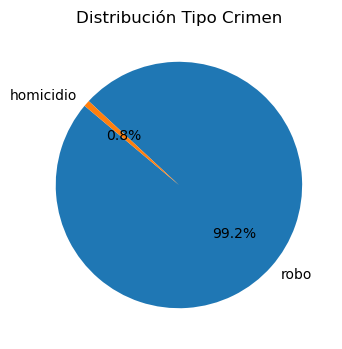

In [6]:
# Count the occurrences of each crime type
crime_counts = delitos['tipo_crimen'].value_counts()
display(crime_counts)
# Plot the pie chart
plt.figure(figsize=(4, 4))
plt.pie(crime_counts, labels=crime_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribución Tipo Crimen')
plt.show()

,count,mean,min,25%,50%,75%,max
fecha_hora_local,17747,2019-07-17 15:31:51.030596864-05:00,2019-06-01 00:00:00-05:00,2019-06-25 06:25:00-05:00,2019-07-18 13:45:00-05:00,2019-08-08 19:00:00-05:00,2019-08-31 23:48:00-05:00


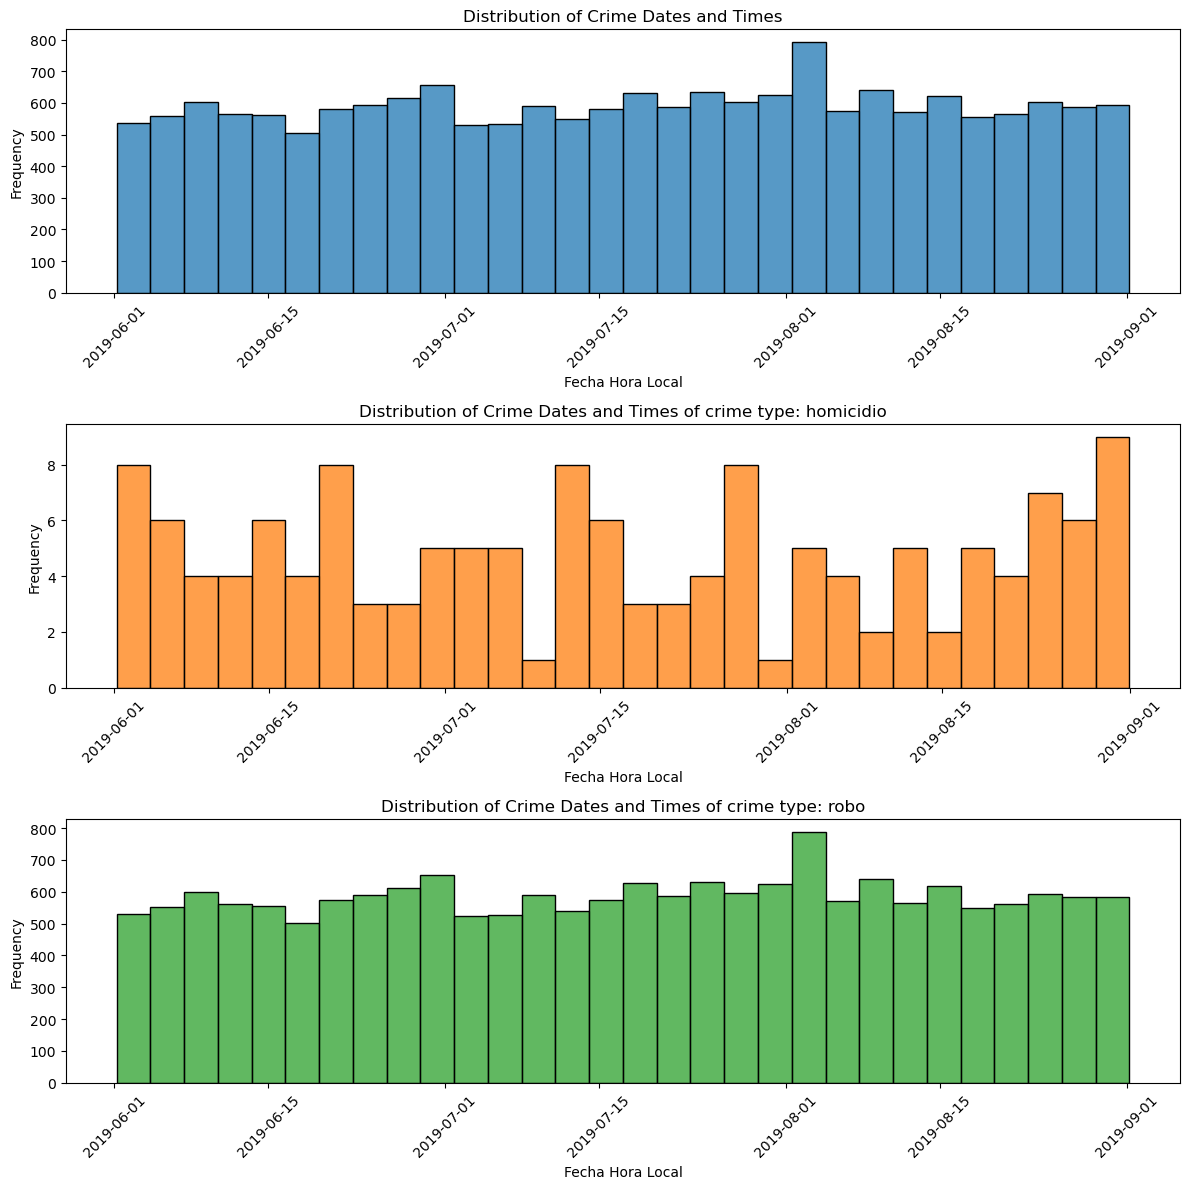

In [7]:
display(delitos[['fecha_hora_local']].describe().T)

n_rows = 3
colors = plt.cm.tab10(np.arange(0, n_rows))
fig, ax = plt.subplots(n_rows,1,figsize=(12,n_rows*4))
axs = ax.flatten()

# Plot histogram
sns.histplot(delitos['fecha_hora_local'], bins=30, kde=False, ax=axs[0])
axs[0].set_title('Distribution of Crime Dates and Times')
axs[0].set_xlabel('Fecha Hora Local')
axs[0].set_ylabel('Frequency')
axs[0].tick_params(axis='x', rotation=45)

fltr_homicidio = delitos["tipo_crimen"] == "homicidio"
fltr_robo = delitos["tipo_crimen"] == "robo"

for i,tc in enumerate(delitos["tipo_crimen"].unique()):

    fltr_categ = delitos["tipo_crimen"] == tc

    sns.histplot(delitos.loc[fltr_categ,'fecha_hora_local'], bins=30, kde=False, ax=axs[i+1], color=colors[i+1])
    axs[i+1].set_title('Distribution of Crime Dates and Times of crime type: {}'.format(tc))
    axs[i+1].set_xlabel('Fecha Hora Local')
    axs[i+1].set_ylabel('Frequency')
    axs[i+1].tick_params(axis='x', rotation=45)




plt.tight_layout()
plt.show()

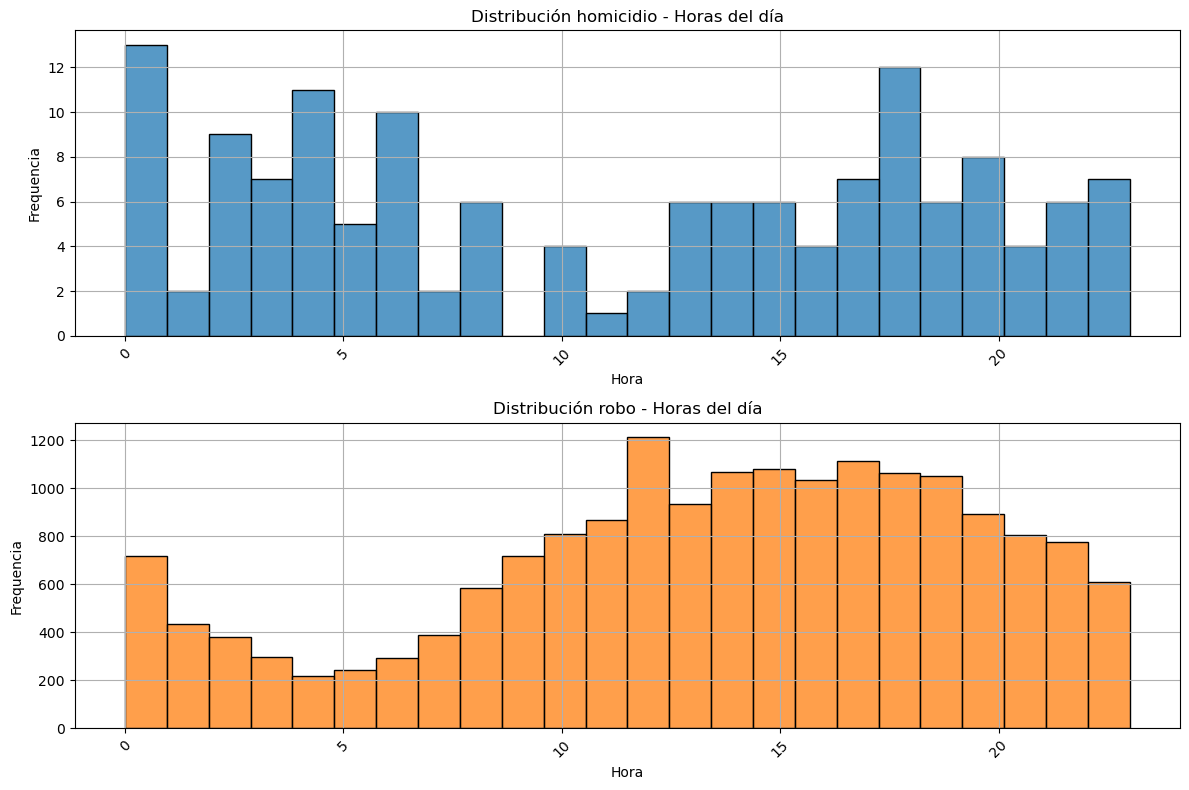

In [8]:
# Distribucion Tipo de Crimen por hora del dia
fltr_homicidio = delitos["tipo_crimen"] == "homicidio"
fltr_robo = delitos["tipo_crimen"] == "robo"


n_rows = 2
colors = plt.cm.tab10(np.arange(0, n_rows))
fig, ax = plt.subplots(n_rows,1,figsize=(12,n_rows*4))
axs = ax.flatten()

for i,tc in enumerate(delitos["tipo_crimen"].unique()):

    fltr_categ = delitos["tipo_crimen"] == tc

    sns.histplot(delitos.loc[fltr_categ,'hora'], bins=24, kde=False, ax=axs[i],color=colors[i])
    axs[i].set_title('Distribución {} - Horas del día'.format(tc))
    axs[i].set_xlabel('Hora')
    axs[i].set_ylabel('Frequencia')
    axs[i].tick_params(axis='x', rotation=45)
    axs[i].grid(True)


plt.tight_layout()
plt.show()

In [9]:
gr_areas_comunitarias = delitos.groupby("nro_area_comunitaria")[["tipo_crimen"]].count()

print("cantidad de comunidades en los datos: {}".format(gr_areas_comunitarias.shape[0]))
print()

print("Top de comunidades con Mas delitos")
display(gr_areas_comunitarias.head())

print("Top de comunidades con Menos delitos")
display(gr_areas_comunitarias.tail())

cantidad de comunidades en los datos: 77

Top de comunidades con Mas delitos


,tipo_crimen
nro_area_comunitaria,
1,377
2,280
3,266
4,169
5,99


Top de comunidades con Menos delitos


,tipo_crimen
nro_area_comunitaria,
73,165
74,21
75,124
76,163
77,228


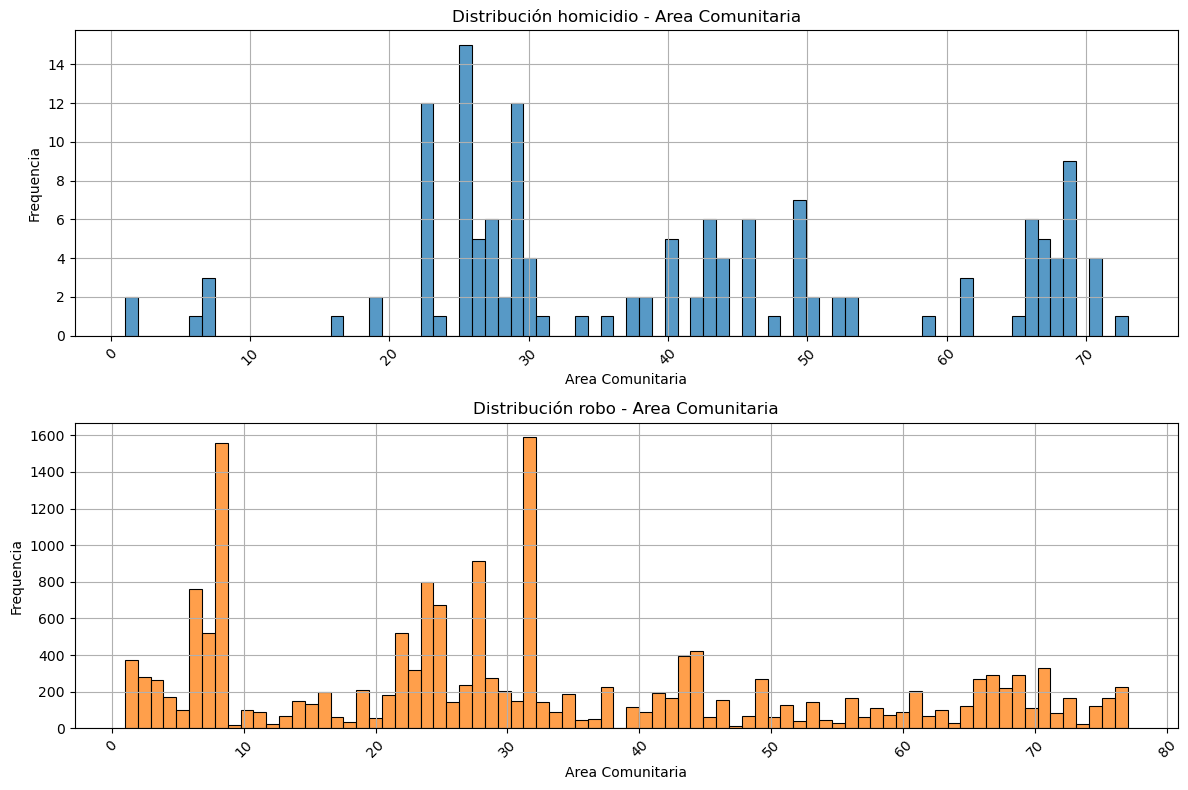

In [10]:
# Distribucion Tipo de Crimen por hora del dia
fltr_homicidio = delitos["tipo_crimen"] == "homicidio"
fltr_robo = delitos["tipo_crimen"] == "robo"


n_rows = 2
colors = plt.cm.tab10(np.arange(0, n_rows))
fig, ax = plt.subplots(n_rows,1,figsize=(12,n_rows*4))
axs = ax.flatten()

for i,tc in enumerate(delitos["tipo_crimen"].unique()):

    fltr_categ = delitos["tipo_crimen"] == tc

    sns.histplot(delitos.loc[fltr_categ,'nro_area_comunitaria'], bins=78, kde=False, ax=axs[i],color=colors[i])
    axs[i].set_title('Distribución {} - Area Comunitaria'.format(tc))
    axs[i].set_xlabel('Area Comunitaria')
    axs[i].set_ylabel('Frequencia')
    axs[i].tick_params(axis='x', rotation=45)
    axs[i].grid(True)


plt.tight_layout()
plt.show()

(Utilice este espacio para describir su procedimiento)

#### 1.2. Barrios de Chicago

También en la carpeta `data` se encuentran los archivos con los polígonos de las áreas comunitarias en un archivo comprimido llamado `Areas_comunitarias_Chicago.zip`. Genere un mapa interactivo con un popup con el nombre del area comunitaria.

In [11]:
# Descomprimir el archivo ZIP
#with zipfile.ZipFile('data/Areas_comunitarias_Chicago.zip', 'r') as zip_ref:
#    zip_ref.extractall('data/')

# Encontrar el archivo shapefile descomprimido
shp_file = [f for f in os.listdir('data/') if f.endswith('.shp')][0]
shp_path = os.path.join('data/', shp_file)

In [13]:
areas = gpd.read_file(shp_path)
print("cantidad de poligonos cargados: {}".format(areas.shape[0]))
print("cantidad de comunidades unicas cargadas{}".format(areas['community'].nunique()))

cantidad de poligonos cargados: 77
cantidad de comunidades unicas cargadas77


In [16]:
#Mapa base
chicago_map = folium.Map(location = [41.881998, -87.627800], tiles = "OpenStreetMap", zoom_start = 10)

#capa areas
for _, row in areas.iterrows():
    folium.GeoJson(
        row['geometry'],
        popup=folium.Popup("Nombre Comunidad: {}".format(row['community']))
    ).add_to(chicago_map)

#Display el mapa
chicago_map

(Utilice este espacio para describir su procedimiento).

### 2.   Análisis distribución del crimen por barrios

#### 2.1.  Genere una tabla descriptiva donde se muestra el número total de delitos, el número total de robos y el número total de homicidios, y como porcentaje de total por barrios. La tabla debe contener ademas una fila final donde se muestre el total para la ciudad. Describa los resultados que obtiene.


In [25]:
resumen = delitos.groupby('nro_area_comunitaria').agg(
    total_robos=('tipo_crimen', lambda x: (x == 'robo').sum()),
    total_homicidios=('tipo_crimen', lambda x: (x == 'homicidio').sum()),
    total_delitos_comunidad=('tipo_crimen', 'size')
).reset_index()  # Reset index to keep 'nro_area_comunitaria' as a column

resumen['porcentaje_robos'] = (resumen['total_robos'] / resumen['total_delitos_comunidad'].sum()) * 100
resumen['porcentaje_homicidios'] = (resumen['total_homicidios'] / resumen['total_delitos_comunidad'].sum()) * 100
resumen['total_ciudad'] = resumen["total_delitos_comunidad"].sum()

resumen.sort_values(by="total_homicidios", ascending=False)

,nro_area_comunitaria,total_robos,total_homicidios,total_delitos_comunidad,porcentaje_robos,porcentaje_homicidios,total_ciudad
24,25,671,15,686,3.780921,0.084521,17747
22,23,319,12,331,1.797487,0.067617,17747
28,29,277,12,289,1.560827,0.067617,17747
68,69,289,9,298,1.628444,0.050713,17747
48,49,270,7,277,1.521384,0.039443,17747
...,...,...,...,...,...,...,...
34,35,186,0,186,1.048064,0.000000,17747
1,2,280,0,280,1.577731,0.000000,17747
40,41,194,0,194,1.093143,0.000000,17747
44,45,63,0,63,0.354990,0.000000,17747


(Utilice este espacio para describir el procedimiento, análisis, y conclusiones)

#### 2.2. Genere una gráfica de dispersión entre el total de homicidios y robos por barrios. Incluya en la gráfica la recta de regresión que mejor ajusta a esos datos. Describa los resultados que obtiene.

In [219]:
# Utilice este espacio para escribir el código.

resumen["z_score_total_robos"] = (resumen['total_robos'] - resumen['total_robos'].mean()) / resumen['total_robos'].std()
resumen["z_score_total_homicidios"] = (resumen['total_homicidios'] - resumen['total_homicidios'].mean()) / resumen['total_homicidios'].std()

resumen

,nro_area_comunitaria,total_robos,total_homicidios,total_delitos_comunidad,porcentaje_robos,porcentaje_homicidios,total_ciudad,z_score_total_robos,z_score_total_homicidios
0,1,375,2,377,2.113033,0.011270,17747,0.514229,0.042173
1,2,280,0,280,1.577731,0.000000,17747,0.180519,-0.607297
2,3,266,0,266,1.498845,0.000000,17747,0.131340,-0.607297
3,4,169,0,169,0.952274,0.000000,17747,-0.209396,-0.607297
4,5,99,0,99,0.557841,0.000000,17747,-0.455288,-0.607297
...,...,...,...,...,...,...,...,...,...
72,73,164,1,165,0.924100,0.005635,17747,-0.226960,-0.282562
73,74,21,0,21,0.118330,0.000000,17747,-0.729282,-0.607297
74,75,124,0,124,0.698710,0.000000,17747,-0.367470,-0.607297
75,76,163,0,163,0.918465,0.000000,17747,-0.230473,-0.607297


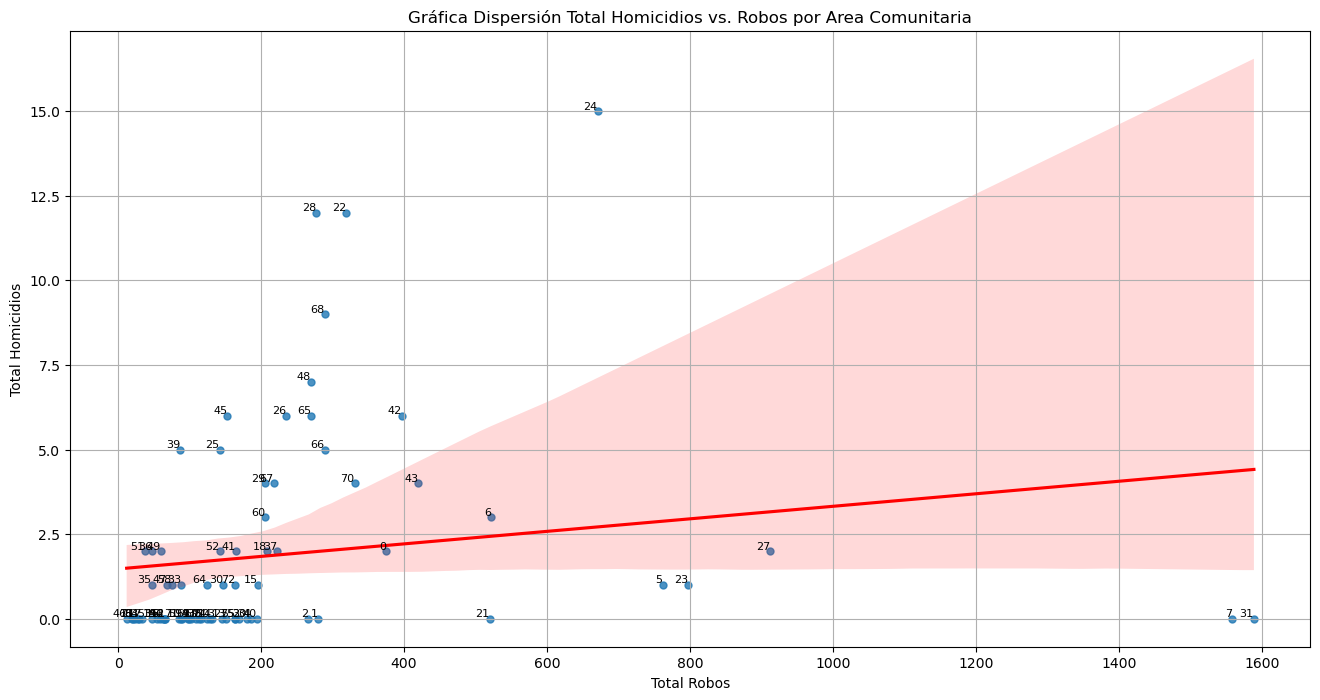

In [31]:
plt.figure(figsize=(16, 8))
ax = sns.regplot(x='total_robos', y='total_homicidios', data=resumen.iloc[:-1], scatter_kws={'s':25}, line_kws={'color':'red'})

# Add annotations for each point
for i, row in resumen.iloc[:-1].iterrows():
    ax.text(row['total_robos'], row['total_homicidios'], str(i),
            fontsize=8, ha='right', va='bottom')

plt.title('Gráfica Dispersión Total Homicidios vs. Robos por Area Comunitaria')
plt.xlabel('Total Robos')
plt.ylabel('Total Homicidios')
plt.grid(True)
plt.show()

(Utilice este espacio para describir el procedimiento, análisis, y conclusiones)

### 3. Distribución espacial del delito

#### 3.1 Distribución respecto al centro de la ciudad

Tomando como centro de la ciudad las coordenadas (-87.627800, 41.881998), estime funciones de densidad que muestren gráficamente el gradiente del total de robos, y homicidios, como función de la distancia al centro de la ciudad. Explique cómo midió las distancias incluyendo que medida de distancia utilizó. Para elegir el ancho de banda y la función de kernel más apropiados utilice validación cruzada usando todas las opciones posibles de kernel. Describa los resultados que obtiene.

In [32]:
areas.crs

<Geographic 2D CRS: GEOGCS["WGS84(DD)",DATUM["WGS84",SPHEROID["WGS84", ...>
Name: WGS84(DD)
Axis Info [ellipsoidal]:
- lon[east]: Longitude (degree)
- lat[north]: Latitude (degree)
Area of Use:
- undefined
Datum: WGS84
- Ellipsoid: WGS84
- Prime Meridian: Greenwich

In [48]:
db = pd.DataFrame({
    "lugar": ["centro_ciudad"],
    "lat": [41.881998],
    "lon": [-87.627800]
    })
gd_centro = gpd.GeoDataFrame(db, geometry = gpd.points_from_xy(db.lon, db.lat))
gd_centro.crs = "EPSG:4326"
# validando la proyeccion de los datos
print(gd_centro.crs)

EPSG:4326


In [49]:
delitos

gd_delitos = gpd.GeoDataFrame(delitos, geometry = gpd.points_from_xy(delitos.lon, delitos.lat))
gd_delitos.crs = "EPSG:4326"
# validando la proyeccion de los datos
print(gd_delitos.crs)

EPSG:4326


Se busca en la pagina https://epsg.io/26916-1188 para determinar cual es la mejor proyeccion para chicago-illinois y se obtiene que: EPSG:26916 es la mejor, ahora se procede a transformar cada uno de los dataframe geograficos a esta proyeccion

In [95]:
areas = areas.to_crs("EPSG:4326")
gd_centro = gd_centro.to_crs("EPSG:4326")
gd_delitos = gd_delitos.to_crs("EPSG:4326")

In [195]:
# calculo la distancia geodésica
def calcular_distancia(centro, coord):
    return geodesic(centro, coord).kilometers

In [206]:
centro_ciudad = (41.881998, -87.627800)
gd_delitos["distancia_centro"] = gd_delitos.apply(lambda row: calcular_distancia(centro_ciudad, (row["lat"], row["lon"])), axis=1)
display(gd_delitos[["distancia_centro"]].describe())
gd_delitos.head()

,distancia_centro
count,17747.000000
mean,9.017958
std,5.992482
min,0.023621
25%,3.891877
50%,8.674172
75%,13.384658
max,27.285786


,fecha,tipo_crimen,nro_area_comunitaria,lat,lon,utc_time,fecha_hora_local,hora,dia,geometry,distancia_centro
0,2019-06-01T05:07:00Z,homicidio,23,41.897950,-87.728625,2019-06-01 05:07:00+00:00,2019-06-01 00:07:00-05:00,0,Saturday,POINT (-87.72863 41.89795),8.553361
1,2019-06-01T10:09:00Z,homicidio,71,41.753272,-87.648963,2019-06-01 10:09:00+00:00,2019-06-01 05:09:00-05:00,5,Saturday,POINT (-87.64896 41.75327),14.405275
2,2019-06-01T12:46:00Z,homicidio,25,41.877622,-87.750728,2019-06-01 12:46:00+00:00,2019-06-01 07:46:00-05:00,7,Saturday,POINT (-87.75073 41.87762),10.215364
3,2019-06-01T11:35:00Z,homicidio,16,41.960145,-87.699654,2019-06-01 11:35:00+00:00,2019-06-01 06:35:00-05:00,6,Saturday,POINT (-87.69965 41.96015),10.529419
4,2019-06-02T09:39:00Z,homicidio,37,41.804773,-87.633256,2019-06-02 09:39:00+00:00,2019-06-02 04:39:00-05:00,4,Sunday,POINT (-87.63326 41.80477),8.589379


In [120]:
from sklearn.model_selection import GridSearchCV

In [214]:
bandwidths = 10 ** np.linspace(-1, 1, 50)

param_grid = {
    'bandwidth': bandwidths, 
    'kernel': ['gaussian', 'tophat', 'epanechnikov', 'exponential', 'linear', 'cosine']
}

In [272]:
def estimar_kde(distancias, param_grid):
    kde = KernelDensity()
    grid = GridSearchCV(kde, param_grid = param_grid, cv=10, n_jobs=-1)
    grid.fit(distancias[:, None])  # Ajustamos el modelo
    resultados_kde = pd.DataFrame(grid.cv_results_)
    return resultados_kde, grid.best_estimator_, grid.best_params_


def estimar_regla_scott(distancias):
    band_scott = 1.06*distancias.std()*(len(distancias)**-(1/5))
    return band_scott


def estimar_regla_silverman(distancias):
    IQR = distancias.quantile(0.75) - distancias.quantile(0.25)
    stdr = distancias.std()
    val = min(stdr, IQR/1.35)
    band_silverman = 0.9*val*(len(distancias)**-(1/5))
    return band_silverman

In [268]:
# Estimar densidad para robos
fltr_categ = gd_delitos["tipo_crimen"] == "robo"


resultados_kde_robos, best_kde_robos, best_params_robos = estimar_kde(gd_delitos.loc[fltr_categ,'distancia_centro'].values, param_grid)
print(f"Mejores parámetros para robos: {best_params_robos}")

Mejores parámetros para robos: {'bandwidth': 0.10985411419875583, 'kernel': 'linear'}


c:\Users\Paul\anaconda3\envs\tf\lib\site-packages\sklearn\model_selection\_search.py:976: UserWarning: One or more of the test scores are non-finite: [-2668.13905289           -inf           -inf -2660.94904126
           -inf           -inf -2669.31566757 -2677.28685455
 -2662.72826241 -2663.00188205 -2650.74447531 -2660.81019973
 -2670.4266756  -2674.95157674 -2665.32576733 -2664.9674003
 -2653.91149838 -2663.56242482 -2671.50735936 -2672.8554352
 -2666.5411065  -2666.86486389 -2656.25299263 -2665.13503154
 -2672.58827693 -2671.47693083 -2667.05457323 -2668.71330361
 -2657.99990399 -2665.99207409 -2673.69414802 -2673.05723964
 -2667.7273778  -2670.53132144 -2659.66684728 -2666.86524148
 -2674.84433554 -2674.93172207 -2668.73169149 -2672.33703022
 -2661.4214571  -2667.95979846 -2676.05409746 -2675.53610867
 -2669.75825534 -2674.14811716 -2663.09468348 -2669.05117857
 -2677.33539509 -2676.69505594 -2670.8130562  -2675.98201573
 -2664.70051638 -2670.14742753 -2678.69702635 -2675.9466899

In [239]:
bw_robos_scott = estimar_regla_scott(gd_delitos.loc[fltr_categ,'distancia_centro'])
best_kd_robo_scott = KernelDensity(bandwidth=bw_robos_scott, kernel="gaussian")
best_kd_robo_scott.fit(gd_delitos.loc[fltr_categ,'distancia_centro'].values[:,None])

bw_robos_silver = estimar_regla_silverman(gd_delitos.loc[fltr_categ,'distancia_centro'])
best_kd_robo_silver = KernelDensity(bandwidth=bw_robos_silver, kernel="gaussian")
best_kd_robo_silver.fit(gd_delitos.loc[fltr_categ,'distancia_centro'].values[:,None])

print(bw_robos_scott,bw_robos_silver)

0.9001784850150425 0.7643024872769228


In [342]:
resultados_kde_robos.sort_values(by='rank_test_score').head(20)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_bandwidth,param_kernel,params,split0_test_score,split1_test_score,split2_test_score,...,split13_test_score,split14_test_score,split15_test_score,split16_test_score,split17_test_score,split18_test_score,split19_test_score,mean_test_score,std_test_score,rank_test_score
10,0.005177,0.000507,0.016667,0.000724,0.109854,linear,"{'bandwidth': 0.10985411419875583, 'kernel': '...",-2688.895628,-2628.298726,-2612.957033,...,-2553.436156,-2675.564014,-2675.122500,-2668.404542,-2649.980774,-2695.023729,-2760.891418,-2650.744475,45.136282,1
16,0.005227,0.000485,0.018902,0.000718,0.120679,linear,"{'bandwidth': 0.12067926406393285, 'kernel': '...",-2691.801360,-2631.597600,-2615.123508,...,-2559.509193,-2678.533099,-2677.778472,-2671.386105,-2653.215860,-2696.714930,-2763.805805,-2653.911498,44.511945,2
22,0.005477,0.000487,0.021303,0.003036,0.132571,linear,"{'bandwidth': 0.13257113655901093, 'kernel': '...",-2693.562022,-2633.499172,-2617.512561,...,-2564.682626,-2680.236716,-2679.966764,-2673.684932,-2655.353906,-2698.343825,-2766.179061,-2656.252993,44.030094,3
28,0.005533,0.000461,0.022612,0.001270,0.145635,linear,"{'bandwidth': 0.14563484775012436, 'kernel': '...",-2694.416262,-2634.783914,-2619.942160,...,-2568.365126,-2681.291192,-2681.915172,-2675.455424,-2656.889933,-2699.563790,-2768.007086,-2657.999904,43.707799,4
34,0.005801,0.000484,0.024053,0.001359,0.159986,linear,"{'bandwidth': 0.15998587196060582, 'kernel': '...",-2695.344313,-2636.286903,-2622.403111,...,-2571.287306,-2682.143229,-2683.805841,-2676.925851,-2658.350172,-2700.591808,-2769.229176,-2659.666847,43.368260,5
11,0.005076,0.000326,0.019447,0.000840,0.109854,cosine,"{'bandwidth': 0.10985411419875583, 'kernel': '...",-2698.012921,-2637.437080,-2623.587741,...,-2568.885192,-2684.941500,-2682.993479,-2677.939907,-2660.433660,-2704.440078,-2769.754223,-2660.810200,44.000082,6
3,0.005226,0.000714,0.534997,0.021675,0.1,exponential,"{'bandwidth': 0.1, 'kernel': 'exponential'}",-2695.969954,-2637.970393,-2627.245841,...,-2568.456457,-2683.271366,-2684.011312,-2676.275924,-2661.065378,-2701.422417,-2765.003512,-2660.949041,42.698761,7
40,0.005677,0.000508,0.025106,0.000680,0.175751,linear,"{'bandwidth': 0.1757510624854792, 'kernel': 'l...",-2696.880625,-2637.796934,-2624.837717,...,-2574.190922,-2683.037040,-2685.443591,-2678.319389,-2659.792154,-2702.111292,-2770.326219,-2661.421457,43.015579,8
8,0.005002,0.000316,0.016734,0.000996,0.109854,epanechnikov,"{'bandwidth': 0.10985411419875583, 'kernel': '...",-2699.791401,-2639.192506,-2625.627496,...,-2572.064549,-2686.602615,-2684.452100,-2679.583243,-2662.361571,-2706.328050,-2771.653301,-2662.728262,43.778487,9
9,0.005150,0.000477,0.570860,0.019707,0.109854,exponential,"{'bandwidth': 0.10985411419875583, 'kernel': '...",-2697.810151,-2639.929592,-2629.863600,...,-2570.390719,-2685.247354,-2685.631761,-2678.006876,-2663.341874,-2703.233670,-2766.231911,-2663.001882,42.494115,10


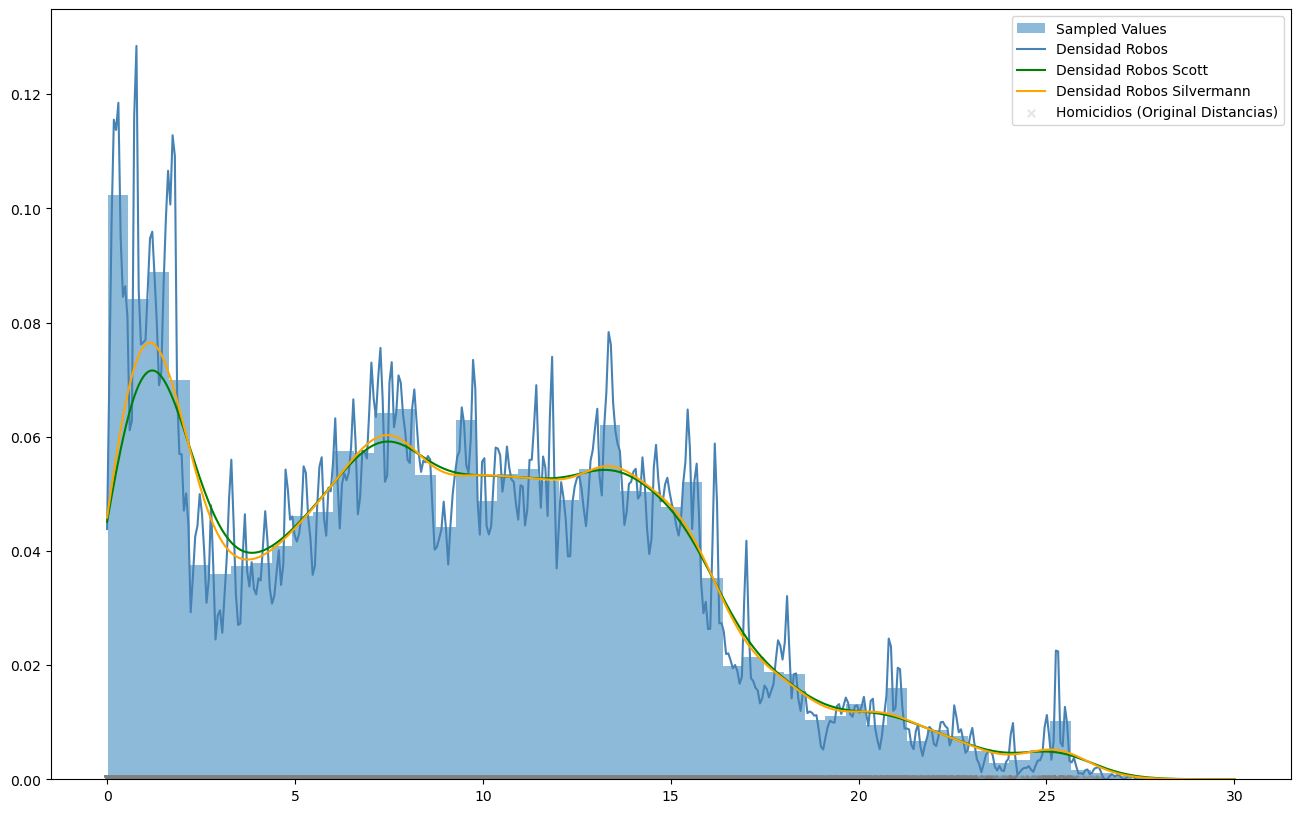

In [285]:
fltr_categ = gd_delitos["tipo_crimen"] == "robo"

fig, ax = plt.subplots(figsize=(16, 10))

ax.hist(gd_delitos.loc[fltr_categ,'distancia_centro'], bins=50, density=True, alpha=0.5, label='Sampled Values')
#ax.fill(x_vec[:, 0], true_density, fc='black', alpha=0.3, label='True Distribution')

distancia_range = np.linspace(0, 30, 500)

log_dens_robos = best_kde_robos.score_samples(distancia_range[:, None])
densidad_robos = np.exp(log_dens_robos)
plt.plot(distancia_range, densidad_robos, label='Densidad Robos', color='steelblue')

log_dens_robos = best_kd_robo_scott.score_samples(distancia_range[:, None])
densidad_robos = np.exp(log_dens_robos)
plt.plot(distancia_range, densidad_robos, label='Densidad Robos Scott', color='green')


log_dens_robos = best_kd_robo_silver.score_samples(distancia_range[:, None])
densidad_robos = np.exp(log_dens_robos)
plt.plot(distancia_range, densidad_robos, label='Densidad Robos Silvermann', color='orange')


plt.scatter(gd_delitos.loc[fltr_categ,"distancia_centro"], np.zeros_like(gd_delitos.loc[fltr_categ,"distancia_centro"]), 
            color='grey', alpha=0.2, s=30, label='Homicidios (Original Distancias)', marker='x')


ax.legend(loc='upper right')
plt.show()

In [274]:
# Estimar densidad para homicidio
fltr_categ = gd_delitos["tipo_crimen"] == "homicidio"


resultados_kde_homicidio, best_kde_homicidio, best_params_homicidio = estimar_kde(gd_delitos.loc[fltr_categ,'distancia_centro'].values, param_grid)
print(f"Mejores parámetros para robos: {best_params_homicidio}")

Mejores parámetros para robos: {'bandwidth': 0.7196856730011519, 'kernel': 'exponential'}


c:\Users\Paul\anaconda3\envs\tf\lib\site-packages\sklearn\model_selection\_search.py:976: UserWarning: One or more of the test scores are non-finite: [-51.04039812         -inf         -inf -44.979722           -inf
         -inf -49.17569715         -inf         -inf -44.45418502
         -inf         -inf -47.64853361         -inf         -inf
 -43.9950981          -inf         -inf -46.40048487         -inf
         -inf -43.595634           -inf         -inf -45.38457078
         -inf         -inf -43.24954202         -inf         -inf
 -44.56240733         -inf         -inf -42.95111193         -inf
         -inf -43.90213994         -inf         -inf -42.6951482
         -inf         -inf -43.37688777         -inf         -inf
 -42.47694008         -inf         -inf -42.96349391         -inf
         -inf -42.29221864         -inf         -inf -42.64159284
         -inf         -inf -42.13710098         -inf         -inf
 -42.39309488         -inf         -inf -42.00802968       

In [275]:
fltr_categ = gd_delitos["tipo_crimen"] == "homicidio"

bw_homicidio_scott = estimar_regla_scott(gd_delitos.loc[fltr_categ,'distancia_centro'])
best_kd_homicidio_scott = KernelDensity(bandwidth=bw_robos_scott, kernel="gaussian")
best_kd_homicidio_scott.fit(gd_delitos.loc[fltr_categ,'distancia_centro'].values[:,None])

bw_homicidio_silver = estimar_regla_silverman(gd_delitos.loc[fltr_categ,'distancia_centro'])
best_kd_homicidio_silver = KernelDensity(bandwidth=bw_robos_silver, kernel="gaussian")
best_kd_homicidio_silver.fit(gd_delitos.loc[fltr_categ,'distancia_centro'].values[:,None])

print(bw_homicidio_scott,bw_homicidio_silver)

1.7209091558808707 1.4611492832950788


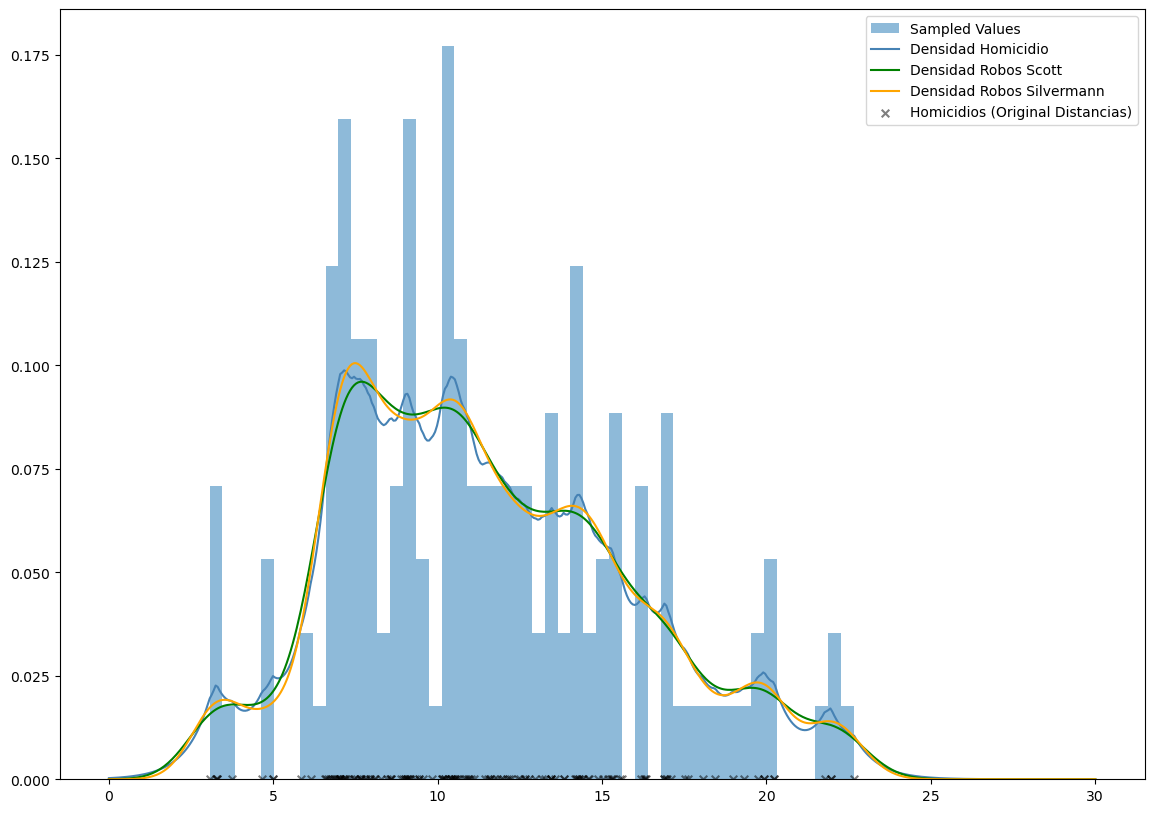

In [288]:
fltr_categ = gd_delitos["tipo_crimen"] == "homicidio"

fig, ax = plt.subplots(figsize=(14, 10))

ax.hist(gd_delitos.loc[fltr_categ,'distancia_centro'], bins=50, density=True, alpha=0.5, label='Sampled Values')

distancia_range = np.linspace(0, 30, 500)
log_dens_homicidio = best_kde_homicidio.score_samples(distancia_range[:, None])
densidad_homicidio = np.exp(log_dens_homicidio)
plt.plot(distancia_range, densidad_homicidio, label='Densidad Homicidio', color='steelblue')


log_dens_homicidio = best_kd_homicidio_scott.score_samples(distancia_range[:, None])
densidad_homicidio = np.exp(log_dens_homicidio)
plt.plot(distancia_range, densidad_homicidio, label='Densidad Robos Scott', color='green')


log_dens_homicidio = best_kd_homicidio_silver.score_samples(distancia_range[:, None])
densidad_homicidio = np.exp(log_dens_homicidio)
plt.plot(distancia_range, densidad_homicidio, label='Densidad Robos Silvermann', color='orange')


plt.scatter(gd_delitos.loc[fltr_categ,"distancia_centro"], np.zeros_like(gd_delitos.loc[fltr_categ,"distancia_centro"]), 
            color='black', alpha=0.5, s=30, label='Homicidios (Original Distancias)', marker='x')


ax.legend(loc='upper right')
plt.show()

(Utilice este espacio para describir el procedimiento, análisis, y conclusiones)

### 3.2 Puntos calientes en la ciudad

Usando `statsmodels` implemente la estimación de densidad bivariada para el total de robos y el total de homicidios. Muestre los resultados usando curvas de nivel en una visualización interactiva. Compare los resultados de estimar usando los anchos de banda: `normal_reference` y `cv_ml`. Explique en que consisten ambas formas de estimar el ancho de banda. Comente sobre los puntos calientes encontrados bajo ambos métodos y su ubicación en la ciudad. (Esto puede tomar mucho tiempo y requerir mucha capacidad computacional, puede aprovechar los recursos de [Google Colab](https://colab.research.google.com/))

In [303]:
import statsmodels.api as sm

In [290]:
gd_delitos.head(1)

,fecha,tipo_crimen,nro_area_comunitaria,lat,lon,utc_time,fecha_hora_local,hora,dia,geometry,distancia_centro
0,2019-06-01T05:07:00Z,homicidio,23,41.89795,-87.728625,2019-06-01 05:07:00+00:00,2019-06-01 00:07:00-05:00,0,Saturday,POINT (-87.72863 41.89795),8.553361


In [305]:
# # Utilice este espacio para escribir el código.

# param_bw = ["normal_reference","cv_ml"]
# arr_crimenes = gd_delitos["tipo_crimen"].unique()

# combinations = [(p,c) for p in param_bw for c in arr_crimenes]

# arr_kdemultivariate = {}
# for p,c in combinations:
#     name = c+"_"+p

#     fltr_tipo_crimen = gd_delitos["tipo_crimen"] == c
#     print(name)
#     arr_kdemultivariate[name] = sm.nonparametric.KDEMultivariate(data=gd_delitos.loc[fltr_tipo_crimen,["lat", "lon"]], var_type='cc', bw=p)


# 33 mins en robo_cv_ml

homicidio_normal_reference
robo_normal_reference
homicidio_cv_ml
robo_cv_ml


c:\Users\Paul\anaconda3\envs\tf\lib\site-packages\statsmodels\nonparametric\kernel_density.py:158: RuntimeWarning: invalid value encountered in log
  L += func(f_i)
c:\Users\Paul\anaconda3\envs\tf\lib\site-packages\statsmodels\nonparametric\kernel_density.py:158: RuntimeWarning: divide by zero encountered in log
  L += func(f_i)


In [ ]:
import pickle


In [306]:
arr_kdemultivariate.keys()

dict_keys(['homicidio_normal_reference', 'robo_normal_reference', 'homicidio_cv_ml', 'robo_cv_ml'])

In [310]:
# Grilla de valores dentro del rango observado (2 dimensiones)
x = np.linspace(min(gd_delitos.lon), max(gd_delitos.lon), 200)
y = np.linspace(min(gd_delitos.lat), max(gd_delitos.lat), 200)
xx, yy = np.meshgrid(x, y)
grid = np.column_stack(( yy.flatten(),xx.flatten()))

In [312]:
dic_preds_kde_bivariate = {}

for k,v in arr_kdemultivariate.items():
    dic_preds_kde_bivariate[k] = v.pdf(data_predict=grid)

In [318]:
gd_delitos.loc[fltr_tipo_crimen,"lon"]

144     -87.616577
145     -87.721559
146     -87.658065
147     -87.566499
148     -87.585797
           ...    
17742   -87.659992
17743   -87.666804
17744   -87.757887
17745   -87.634504
17746   -87.689216
Name: lon, Length: 17603, dtype: float64

homi
robo
homi
robo


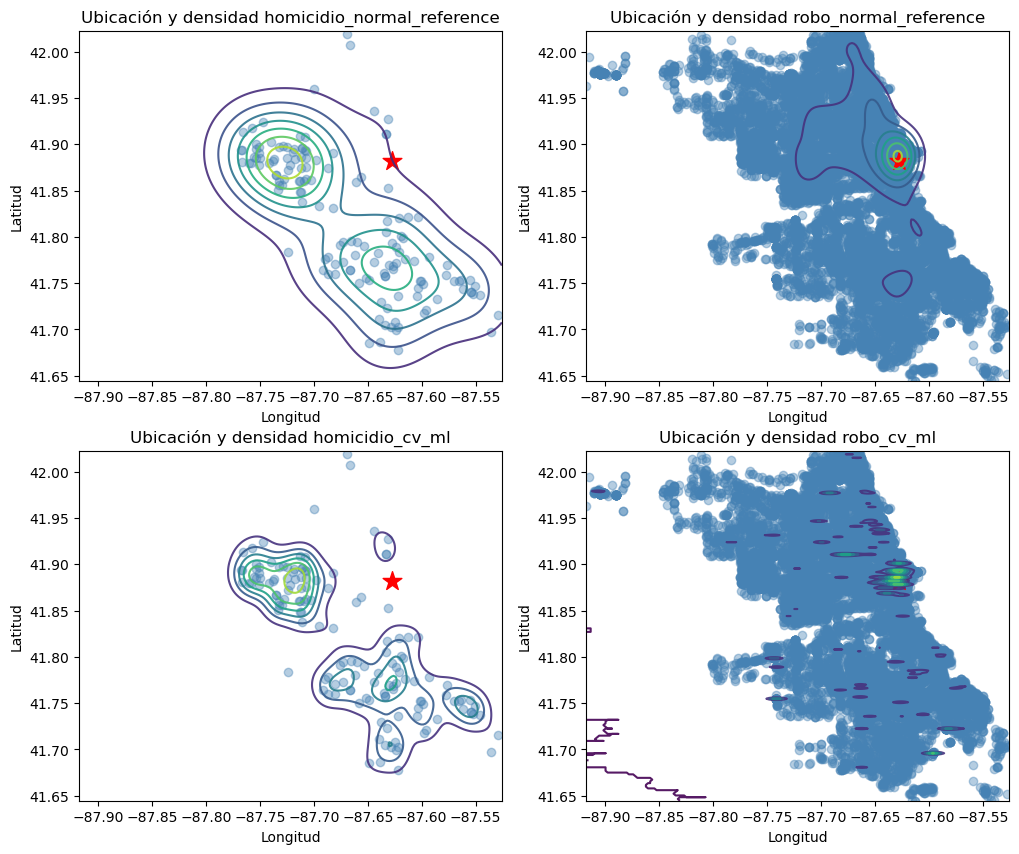

In [321]:
nrows = 2
ncols = int(np.ceil(len(dic_preds_kde_bivariate)/nrows))
fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(nrows*6, ncols*5))
axs = ax.flatten()

centro_ciudad = (41.881998, -87.627800)

for i,(k,v) in enumerate(dic_preds_kde_bivariate.items()):

    if "robo" in k:
        print("robo")
        fltr_tipo_crimen = gd_delitos["tipo_crimen"] == "robo"
        
    elif "homicidio" in k:
        print("homi")
        fltr_tipo_crimen = gd_delitos["tipo_crimen"] == "homicidio"

    

    axs[i].scatter(gd_delitos.loc[fltr_tipo_crimen,"lon"], gd_delitos.loc[fltr_tipo_crimen,"lat"], color='steelblue', alpha=0.4)
    axs[i].contour(
        xx, yy, v.reshape(xx.shape),
        alpha=0.9
    )

    axs[i].scatter(centro_ciudad[1], centro_ciudad[0], color='red', s=200, marker='*', label='Centro Ciudad')
    
    axs[i].set_title('Ubicación y densidad {}'.format(k))
    axs[i].set_xlabel('Longitud')
    axs[i].set_ylabel('Latitud')

In [327]:
#!pip install geojsoncontour

In [328]:
import geojsoncontour

In [322]:
dic_preds_kde_bivariate.keys()

dict_keys(['homicidio_normal_reference', 'robo_normal_reference', 'homicidio_cv_ml', 'robo_cv_ml'])

In [323]:
dic_preds_kde_bivariate["homicidio_normal_reference"]

array([1.21297570e-14, 1.96131998e-14, 3.15592697e-14, ...,
       6.24329898e-05, 4.71554257e-05, 3.54837382e-05])

In [335]:
xx

array([[-87.91764464, -87.91567479, -87.91370495, ..., -87.52958504,
        -87.5276152 , -87.52564535],
       [-87.91764464, -87.91567479, -87.91370495, ..., -87.52958504,
        -87.5276152 , -87.52564535],
       [-87.91764464, -87.91567479, -87.91370495, ..., -87.52958504,
        -87.5276152 , -87.52564535],
       ...,
       [-87.91764464, -87.91567479, -87.91370495, ..., -87.52958504,
        -87.5276152 , -87.52564535],
       [-87.91764464, -87.91567479, -87.91370495, ..., -87.52958504,
        -87.5276152 , -87.52564535],
       [-87.91764464, -87.91567479, -87.91370495, ..., -87.52958504,
        -87.5276152 , -87.52564535]])

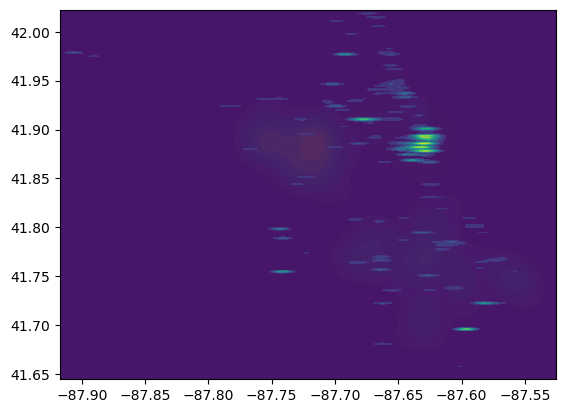

In [336]:
dic_geojson_contours = {}


for k,v in dic_preds_kde_bivariate.items():

    contourf_robos = plt.contourf(xx, yy, v.reshape(xx.shape),
        levels= 8, alpha =0.9, linestyles='None')
                            
    dic_geojson_contours[k] = geojsoncontour.contourf_to_geojson(
        contourf=contourf_robos,
        min_angle_deg=3.0,
        ndigits=5,
        stroke_width=1,
        fill_opacity=0.1)

In [331]:
dic_geojson_contours.keys()

dict_keys(['homicidio_normal_reference', 'robo_normal_reference', 'homicidio_cv_ml', 'robo_cv_ml'])

In [337]:
map = folium.Map(location = [41.881998, -87.627800], tiles = "OpenStreetMap", zoom_start = 10)

# folium.GeoJson(
#     dic_geojson_contours["homicidio_normal_reference"],
#     style_function=lambda x: {
#         'color':     x['properties']['stroke'],
#         'weight':    x['properties']['stroke-width'],
#         'fillColor': '#FFFFFF',
#         'lineColor': '#FFFFFF',
#         'opacity':   0.5,
#     }).add_to(map)

folium.GeoJson(
    dic_geojson_contours["robo_normal_reference"],
    style_function=lambda x: {
        'color':     x['properties']['stroke'],
        'weight':    x['properties']['stroke-width'],
        'fillColor': '#FFFFFF',
        'lineColor': '#FFFFFF',
        'opacity':   0.5,
    }).add_to(map)

map

(Utilice este espacio para describir el procedimiento, análisis, y conclusiones)

## 4. Explicando la ubicación del delito

El objetivo de este punto es encontrar posibles correlaciones  entre el crimen y características de la ciudad. Para ello, utilice los datos de OpenStreetMap y explore si existe una correlación entre el porcentaje del área de la comunidad  dedicado a tiendas (`retail`)  y comercios (`commercial`) y el número total de robos y homicidios en esa comunidad. Ofrezca una explicación intuitiva de por qué cree que aparecen estas correlaciones. (Esto puede tomar mucho tiempo y requerir mucha capacidad computacional, puede aprovechar los recursos de [Google Colab](https://colab.research.google.com/))

In [349]:
!pip uninstall geopandas
#!pip install pyrosm

^C


In [345]:
from pyrosm import osm, get_data

ModuleNotFoundError: No module named 'pyrosm'

In [ ]:
# Bajamos los datos para  Chicago
fp = get_data("Chicago")

# Inicializamos el lector para Chicago 
osm = OSM(fp)

custom_filter = {
    "shop": ["retail"],
    "landuse": ["commercial"]
}

# Extraemos los POIs que cumplen con el filtro
pois = osm.get_pois(custom_filter=custom_filter)

(Utilice este espacio para describir el procedimiento, análisis, y conclusiones)